## Pobranie bibliotek

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Wczytanie danych

In [2]:
comps = pd.read_csv("data/all_comps.csv")
names = pd.read_csv("data/all_names.csv")
results = pd.read_csv("data/all_results.csv")
stats = pd.read_csv("data/all_stats.csv")

## Połączenie dwóch tabel

In [3]:
merged = results.merge(comps, on="id")

### Podział ze względu na rodzaj skoczni

In [32]:
nh = merged[(merged['k-point'] > 75) & (merged['k-point'] < 100)]

In [5]:
lh = merged[(merged['k-point'] > 100) & (merged['k-point'] < 170)]

In [6]:
fh = merged[merged['k-point'] > 170]

## Przebadajmy ogólne trendy w zależności od rodzaju skoczni

### Skocznie normalne

In [30]:
normal_hills = nh[['speed', 'dist', 'wind_comp', 'k-point', 'note_points', 'points']].dropna()
normal_hills

,speed,dist,wind_comp,k-point,note_points,points
12773,87.6,103.0,1.1,95.0,56.5,133.6
12774,87.6,106.0,-4.7,95.0,57.0,134.3
12775,87.6,102.0,-4.0,95.0,55.5,125.5
12776,87.3,98.5,-0.4,95.0,55.0,121.6
12777,87.2,104.0,3.3,95.0,57.0,141.6
...,...,...,...,...,...,...
228925,82.0,74.0,-5.5,90.0,48.0,70.5
228926,82.1,69.5,-5.1,90.0,47.5,61.4
228927,81.5,67.0,-3.8,90.0,45.5,55.7
228928,81.5,67.0,-12.9,90.0,46.0,47.1


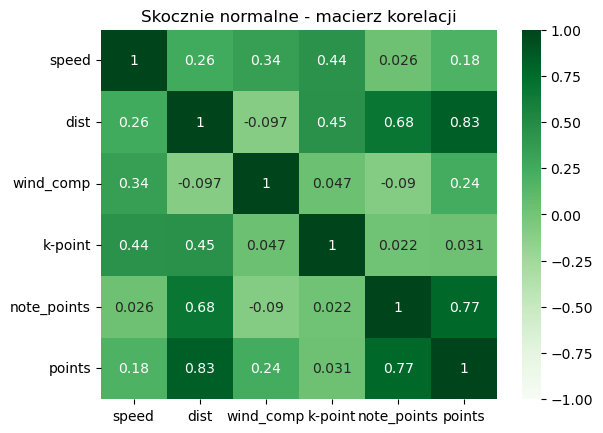

In [8]:
sns.heatmap(normal_hills.corr(), cmap='Greens', annot=True, vmin=-1, vmax=1).set(title="Skocznie normalne - macierz korelacji")
plt.show()

### Skocznie duże

In [9]:
large_hills = lh[['speed', 'dist', 'wind_comp', 'k-point', 'note_points', 'points']].dropna()

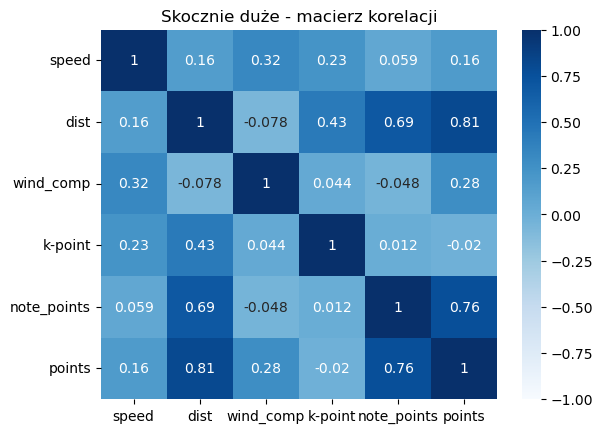

In [10]:
sns.heatmap(large_hills.corr(), cmap='Blues', annot=True, vmin=-1, vmax=1).set(title="Skocznie duże - macierz korelacji")
plt.show()

### Skocznie mamucie

In [11]:
flying_hills = fh[['speed', 'dist', 'wind_comp', 'k-point', 'note_points', 'points']].dropna()

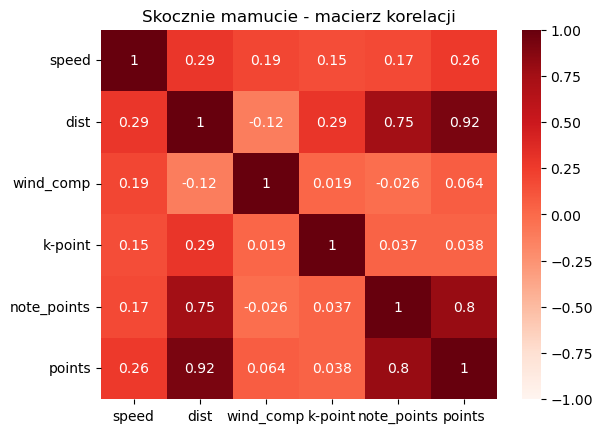

In [12]:
sns.heatmap(flying_hills.corr(), cmap='Reds', annot=True, vmin=-1, vmax=1).set(title="Skocznie mamucie - macierz korelacji")
plt.show()

## Wnioski

#### W tej analizie pod uwagę wzięto jedynie te wiersze, które mają komplet danych. Zatem pominięto treningi i serie próbne, gdzie sędziowie nie oceniają stylu oraz konkursy, w których nie korzystano z przeliczników wiatrowych.

Na podstawie macierzy korelacji można zauważyć, że bez względu na rodzaj skoczni istnieje silna zależność pomiędzy **odległością** uzyskaną przez zawodników, a **notami za styl**. Jest to spowodowane tym, że sędziowie oceniając styl sugerują się odległością i z automatu obniżają noty zawodnikom, którzy nie osiągają punktu konstrukcyjnego.

Ciekawą obserwacją jest niemal **zerowy wpływ wiatru** na **odległości** uzyskiwane przez zawodników.
Może to być spowodowane tym, że gdy warunki się pogarszają, to sędziowie **wydłużają** rozbieg, a jeśli się
poprawiają, to go **skracają** w celu wyrównania szans zawodnikom. Jest to możliwe dzięki wprowadzeniu
**systemu przelicznania prędkości wiatru na punkty** i uwzględnieniu tego w nocie końcowej zawodnika. Dlatego nawet silny wiatr tylni nie powoduje słabego skoku zawodnika, ponieważ uzyskuje on lepszą prędkość, co pozwala na
pokonanie trudnych warunków.

## Analiza warunków wietrznych na skoczniach

Wiatr na skoczni odgrywa znaczącą rolę. Nieraz uniemożliwia przeprowadzenie zawodów albo
powoduje, że zawody nie są sprawiedliwe. Z tego powodu wprowadzono przeliczniki wiatrowe, które
starają się rekompensować niekorzystne warunki dla zawodników. Mają one wielu przeciwników, jednak
jak pokazuje powyższa analiza, mocno minimalizują one wpływ wiatru na uzyskiwane odległości.

Przeanalizujmy teraz, jak zmienny jest wiatr na różnych skoczniach i gdzie konkursy bywają
najbardziej loteryjne. W tym celu policzymy odchylenie standardowe od wartości średniej dla rekompensaty za wiatr.
- z tabeli merged usuniemy konkursy, gdzie nie używano przeliczników
- weźmiemy pod uwagę wind_comp

In [13]:
def wind_analysis(hill):
    """
    hill: rodzaj skoczni. Do wyboru:'normalne', 'duże', 'mamucie'.
    """
    if hill == 'normalne':
        data = nh
    elif hill == 'duże':
        data = lh
    elif hill == 'mamucie':
        data = fh
    cleaned_data = data.dropna(subset = ['wind_comp'])
    cleaned_data = cleaned_data[['wind_comp', 'place']]
    name = "Odchylenie standardowe"
    container = cleaned_data.groupby("place")['wind_comp'].std()
    print(f"Top places ({name} rekompensaty za wiatr):\n {container.sort_values(ascending=False).head()}")
    plt.figure(figsize=(15, 6))
    plt.plot(container)
    plt.title(f"{name} rekompensaty wiatru w różnych lokalizacjach (skocznie {hill})")
    plt.tick_params(axis='x', rotation=90)
    plt.show()

Top places (Odchylenie standardowe rekompensaty za wiatr):
 place
Oberwiesenthal (GER)    11.636901
Sapporo (JPN)           11.222456
Kandersteg (SUI)         8.502224
Ljubno (SLO)             8.392504
Schuchinsk (KAZ)         8.376156
Name: wind_comp, dtype: float64


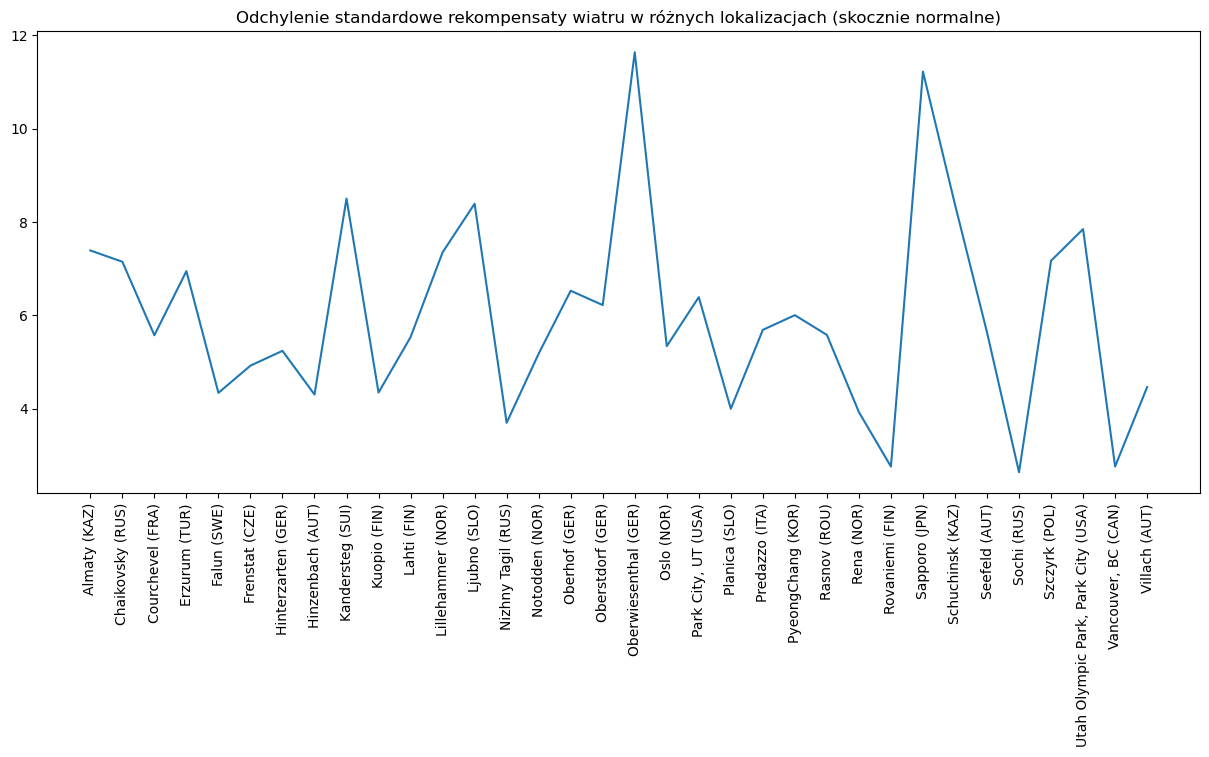

In [14]:
wind_analysis('normalne')

Top places (Odchylenie standardowe rekompensaty za wiatr):
 place
Pragelato (ITA)      12.245943
Zhangjiakou (CHN)    11.147480
Ruka (FIN)           10.063214
Courchevel (FRA)      9.959820
Almaty (KAZ)          9.146012
Name: wind_comp, dtype: float64


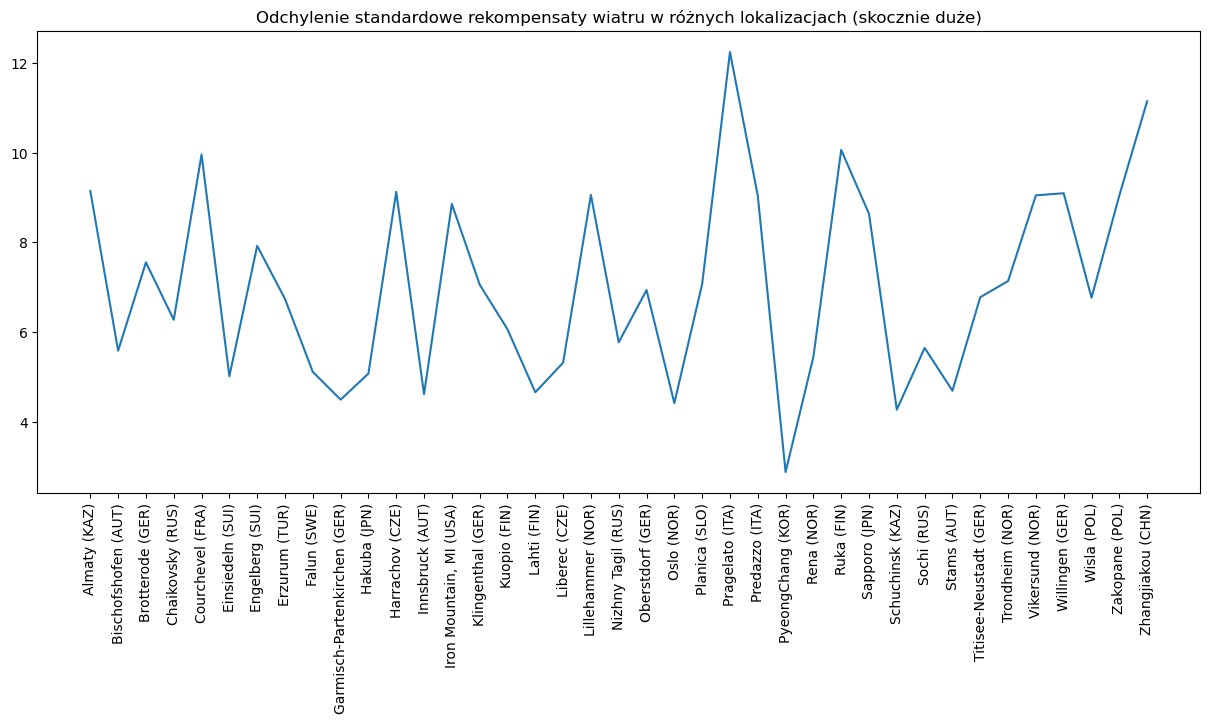

In [15]:
wind_analysis('duże')

Top places (Odchylenie standardowe rekompensaty za wiatr):
 place
Vikersund (NOR)                   10.407049
Planica (SLO)                      8.129405
Oberstdorf (GER)                   7.724851
Tauplitz/Bad Mitterndorf (AUT)     7.567924
Harrachov (CZE)                    6.496813
Name: wind_comp, dtype: float64


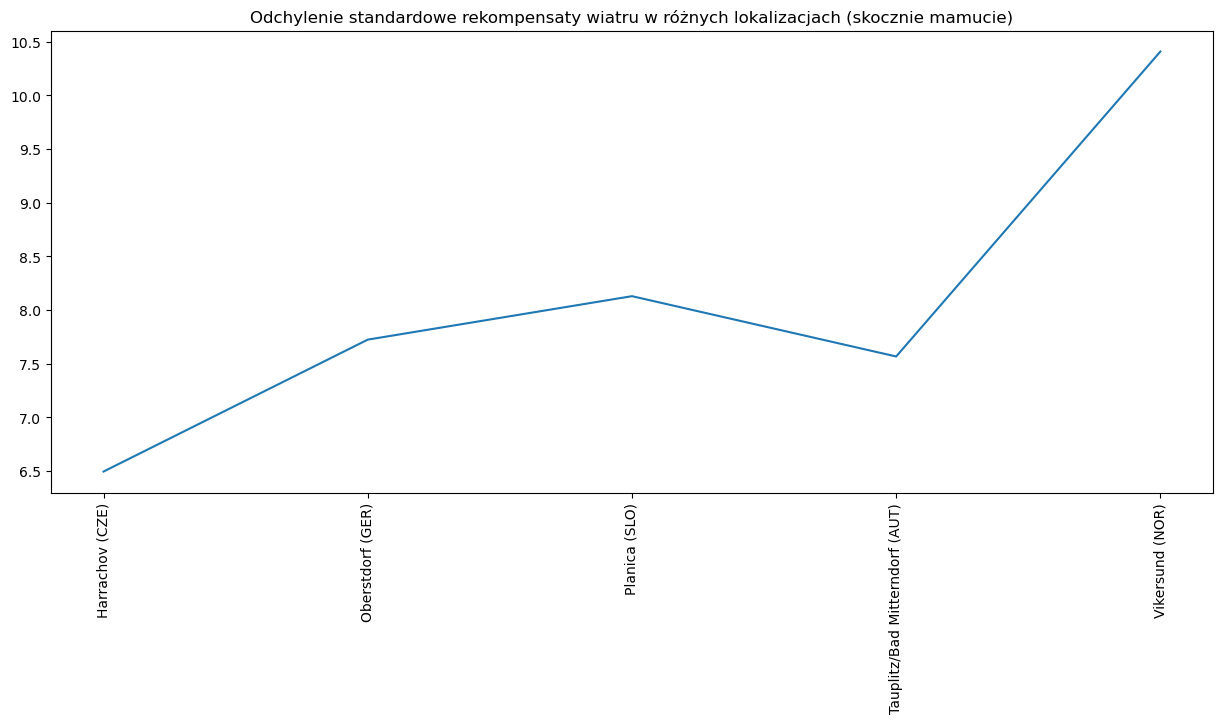

In [16]:
wind_analysis('mamucie')

### Sprawdźmy jeszcze, gdzie wieje najbardziej

W tym celu
- połączymy tabelę comps z tabelą stats
- wyciągniemy średnią maksymalną siłę wiatru

In [17]:
merged_2 = pd.merge(comps, stats, left_on="id", right_on='fis_code')
merged_2 = merged_2[['max_wind', 'avg_wind', 'min_wind', 'place']].dropna()
grouped_wind_front = merged_2.groupby('place')['max_wind'].mean()
grouped_wind_back = merged_2.groupby('place')['min_wind'].mean()

Top places:
 place
Iron Mountain, MI (USA)    2.614754
Oberwiesenthal (GER)       1.849231
Kuopio (FIN)               1.743893
Sapporo (JPN)              1.718855
Frenstat (CZE)             1.540976
Name: max_wind, dtype: float64


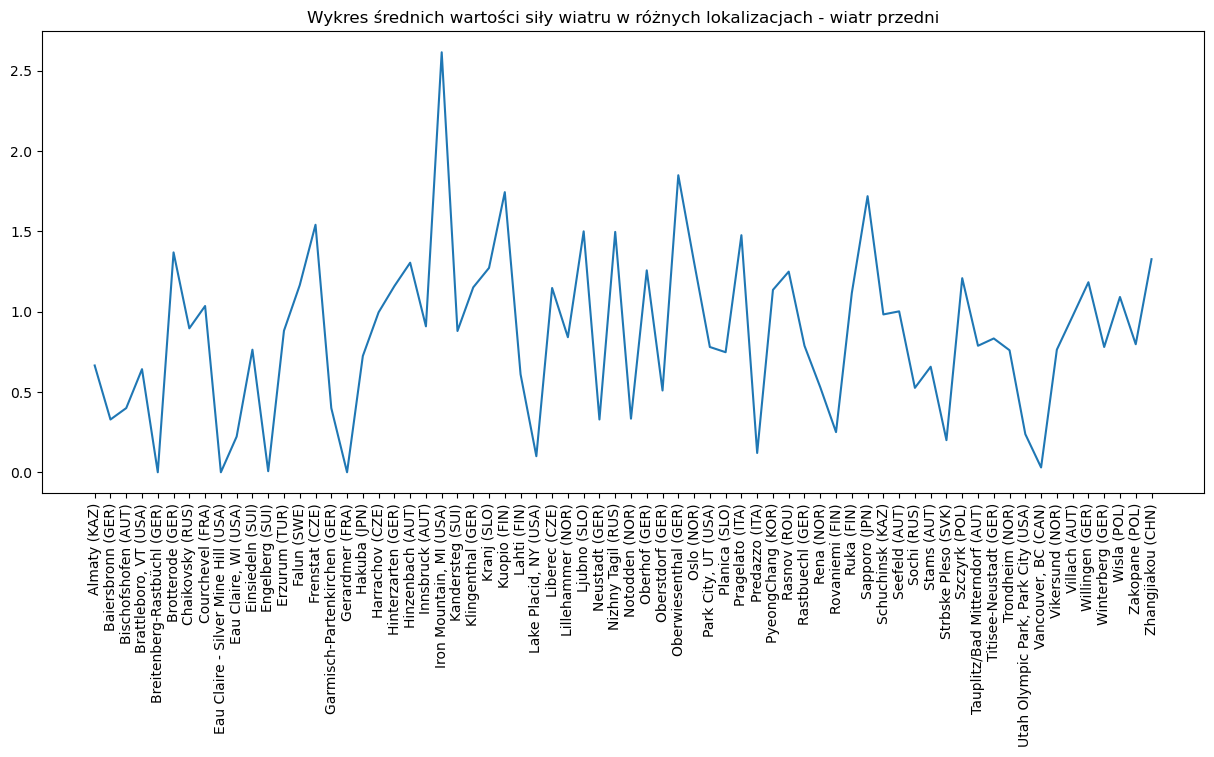

In [18]:
print(f"Top places:\n {grouped_wind_front.sort_values(ascending=False).head()}")
plt.figure(figsize=(15, 6))
plt.plot(grouped_wind_front)
plt.tick_params(axis='x', rotation=90)
plt.title("Wykres średnich wartości siły wiatru w różnych lokalizacjach - wiatr przedni") 
plt.show()

Top places:
 place
Iron Mountain, MI (USA)        0.236066
Kuopio (FIN)                   0.086107
Brattleboro, VT (USA)          0.054839
Gerardmer (FRA)                0.000000
Breitenberg-Rastbüchl (GER)    0.000000
Name: min_wind, dtype: float64


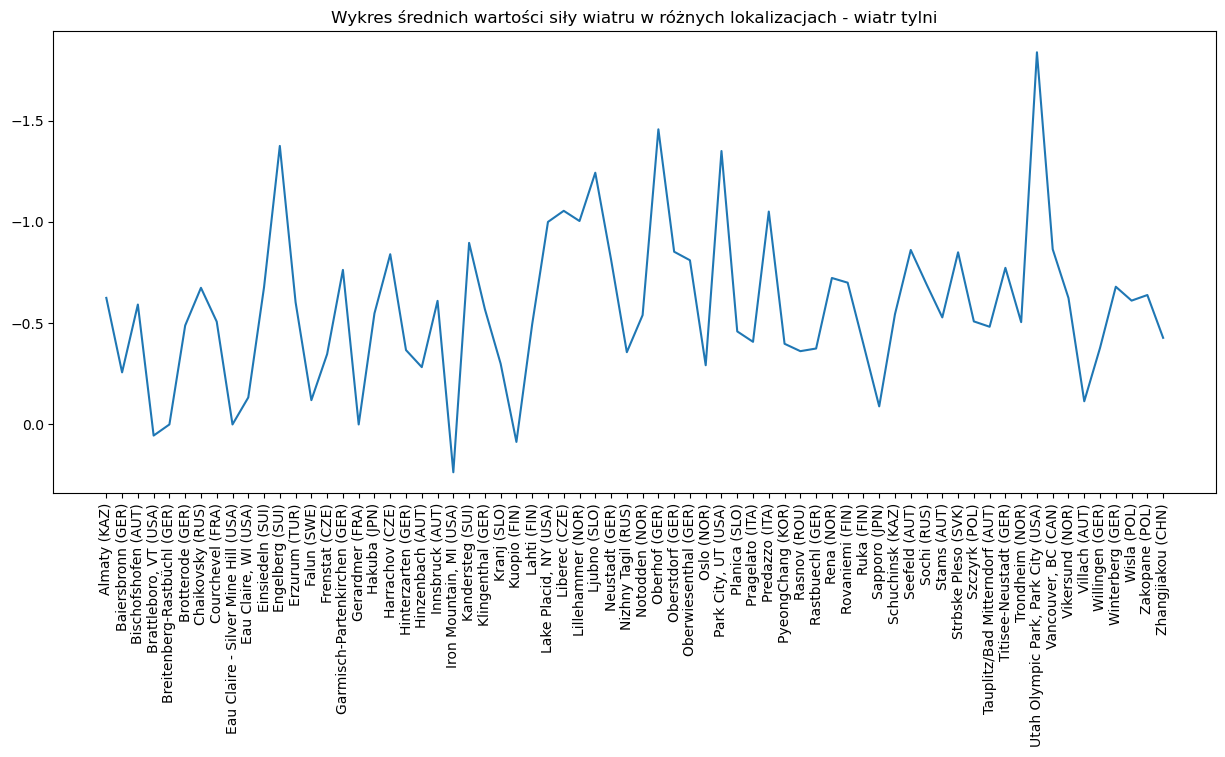

In [19]:
print(f"Top places:\n {grouped_wind_back.sort_values(ascending=False).head()}")
plt.figure(figsize=(15, 6))
plt.plot(grouped_wind_back)
plt.tick_params(axis='x', rotation=90)
plt.gca().invert_yaxis()
plt.title("Wykres średnich wartości siły wiatru w różnych lokalizacjach - wiatr tylni") 
plt.show()

## Analiza konkretnego skoczka

Wykonamy analizę wyników dla wybranego skoczka
- z połączonego zbioru danych weźmiemy wszystkie jego wyniki
- policzymy stosunek dist/k-point. Na tej podstawie wybierzemy ulubioną skocznię
- później dołączymy jeszcze liczbę skoków za hs w zależności od skoczni

In [20]:
def analyse_skijumper(hill, name):
    """
    hill: rodzaj skoczni. Do wyboru: 'normalne', 'duże', 'mamucie'/
    name: nazwa skoczka w konwencji: 'nazwisko imię'
    """
    if hill == 'normalne':
        data = nh
    elif hill == 'duże':
        data = lh
    elif hill == 'mamucie':
        data = fh
    codex = names[names['name'] == name].iloc[0,1]
    res = data[data['codex_x'] == codex]
    res = res[['dist', 'k-point', 'codex_y', 'place', 'hill_size_x', 'note_points']]
    # res = res.copy()
    res['coef'] = res['dist'] / res['k-point']
    res['hs-jumps'] = res['dist'] >= res['hill_size_x']
    grouped_coefs = res.groupby('place')['coef'].mean()
    hs_jumps = res['hs-jumps'].sum()
    mean_notes = res['note_points'].mean()
    print(f"Ilość skoków za HS: {hs_jumps}")
    print(f"Średnia ocena za styl: {mean_notes:.2f}")
    plt.plot(grouped_coefs)
    plt.tick_params(axis='x', rotation=90)
    plt.show()

## Gregor Schlierenzauer

Ilość skoków za HS: 8
Średnia ocena za styl: 54.55


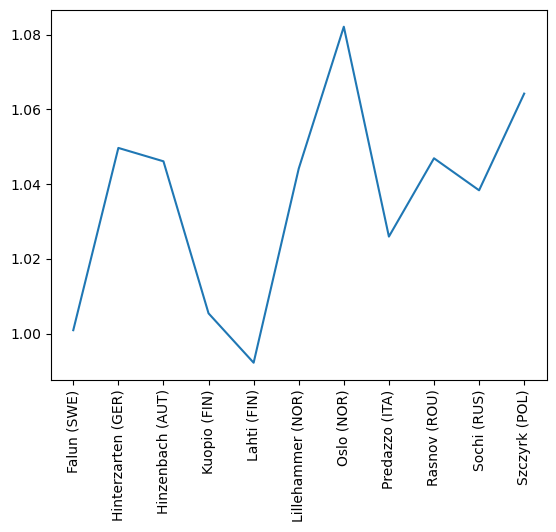

In [21]:
analyse_skijumper('normalne', 'schlierenzauer gregor')

Ilość skoków za HS: 59
Średnia ocena za styl: 54.03


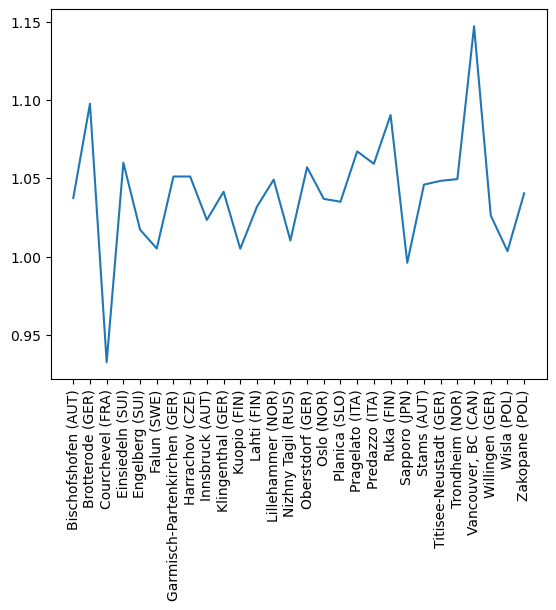

In [22]:
analyse_skijumper('duże', 'schlierenzauer gregor')

Najlepszy średni stosunek między uzyskaną odległością, a punktem konstrukcyjnym Gregor uzyskał w Vancouver (skocznia normalna i skocznia duża liczone razem). No i ma to przełożenie na rzeczywistość, ponieważ w 2009 roku wygrał tam zawody ustanawiając rekord skoczni (149 metrów na skoczni K-125). Rok później podczas igrzysk olimpijskich zdobył tam 2 medale: 1 brązowy indywidualnie i 1 złoty drużynowo.

Ilość skoków za HS: 41
Średnia ocena za styl: 53.33


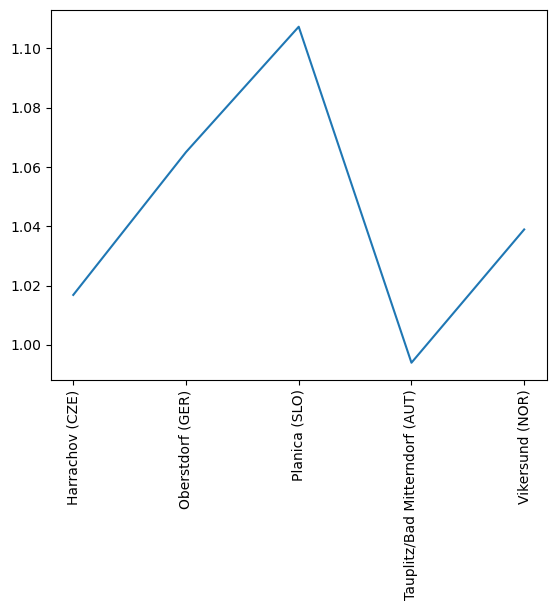

In [23]:
analyse_skijumper('mamucie', 'schlierenzauer gregor')

## Kamil Stoch

Teraz przyjrzyjmy się Polakowi

Ilość skoków za HS: 7
Średnia ocena za styl: 54.11


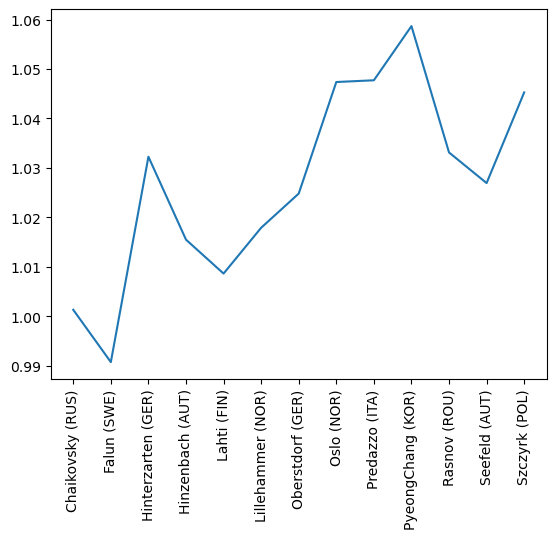

In [24]:
analyse_skijumper('normalne', 'stoch kamil')

Ilość skoków za HS: 105
Średnia ocena za styl: 54.29


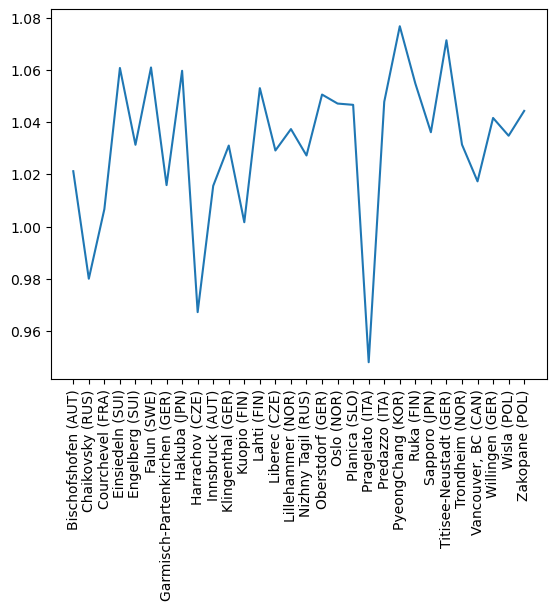

In [25]:
analyse_skijumper('duże', 'stoch kamil')

Ilość skoków za HS: 32
Średnia ocena za styl: 54.42


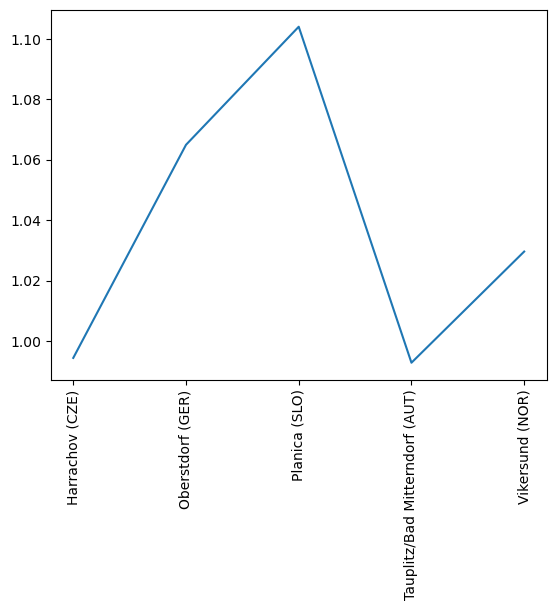

In [26]:
analyse_skijumper('mamucie', 'stoch kamil')

Najlepsze wyniki na mamutach Kamil Stoch uzyskiwał na mamucie w Planicy. Wygrał tam trzykrotnie, najwięcej spośród
innych skoczni mamucich. Najgorsze wyniki uzyskiwał natomiast w Bad Mitterndorf, gdzie nigdy nie wygrał zawodów.